# Install 

In [ ]:
! pip install transformers datasets evaluate
! pip install sacrebleu
! pip install googletrans==3.1.0a0
# ! pip install huggingface_hub

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
import evaluate
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
from transformers import pipeline
from googletrans import Translator

# Back Translation

## Loading Dataset

As soon as we achieve a datafile of data augmentation, I will only load the dataset into the model and re-train the model to estimate the BLEU after augmenting the data. The process of loading data is as following:
1. Import files and get the data
2. Convert data into our correct type in order to feed the corpus into the model
3. Re-training our model and calculate the BLEU score.

In [ ]:
import pathlib
path_to_file = pathlib.Path('../data/gloss-text-augmented.txt')
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context.lower() for target,context in pairs])
  target = np.array([target.lower() for target,context in pairs])

  return target, context

gloss, text = load_data(path_to_file)

In [ ]:
gloss = list(gloss)
text = list(text)

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset


dataset = {'train':Dataset.from_dict({'gloss':gloss,'text': text}),
     'test':Dataset.from_dict({'gloss':gloss,'text': text})
     }

DatasetDict(dataset)
dataset = {'train':Dataset.from_dict({'gloss':gloss,'text': text})
     }

In [ ]:
dataset = dataset["train"].train_test_split(train_size=0.8)

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['gloss', 'text'],
        num_rows: 73696
    })
    test: Dataset({
        features: ['gloss', 'text'],
        num_rows: 18424
    })
})


# Training Model

This section is where we re-train our model. Since the dataset has been changed, there are chances that the evaluation outcome will also vary. Our new BLEU after backtranslating is as shown.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [ ]:
dataset = load_dataset("fuyulinh04/dataset_glstxt")

In [ ]:
source_lang = "gloss"
target_lang = "text"


def preprocess_function(examples):
    inputs = examples[source_lang]
    targets = examples[target_lang]
    model_inputs = tokenizer(inputs,  text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_data = dataset.map(preprocess_function, batched=True)

In [ ]:
sacrebleu = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = sacrebleu.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="transformer_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.401700,0.297129,71.248600,15.535500
2,0.340900,0.262896,73.474700,15.556700
3,0.321900,0.256728,73.859500,15.547500


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, gloss. If text, gloss are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18424
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=13818, training_loss=0.4082573788403119, metrics={'train_runtime': 2226.7916, 'train_samples_per_second': 99.285, 'train_steps_per_second': 6.205, 'total_flos': 2458035504021504.0, 'train_loss': 0.4082573788403119, 'epoch': 3.0})

In [ ]:
# trainer.push_to_hub()

Saving model checkpoint to transformer_model
Configuration saved in transformer_model/config.json
Model weights saved in transformer_model/pytorch_model.bin
tokenizer config file saved in transformer_model/tokenizer_config.json
Special tokens file saved in transformer_model/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/231M [00:00<?, ?B/s]

Upload file runs/Jan05_23-23-56_45b4fdf8f21d/events.out.tfevents.1672961120.45b4fdf8f21d.628.0:  33%|###2     …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/fuyulinh04/transformer_model
   53d5e4e..e0d72ac  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/fuyulinh04/transformer_model
   53d5e4e..e0d72ac  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Bleu', 'type': 'bleu', 'value': 73.8595}]}
To https://huggingface.co/fuyulinh04/transformer_model
   e0d72ac..8839d1d  main -> main

   e0d72ac..8839d1d  main -> main



'https://huggingface.co/fuyulinh04/transformer_model/commit/e0d72ac1da1976183b1b82756e8e920031c937af'

## BLEU Estimation:
After applying back-translation, the BLEU score has varied significantly as shown in the photo below:
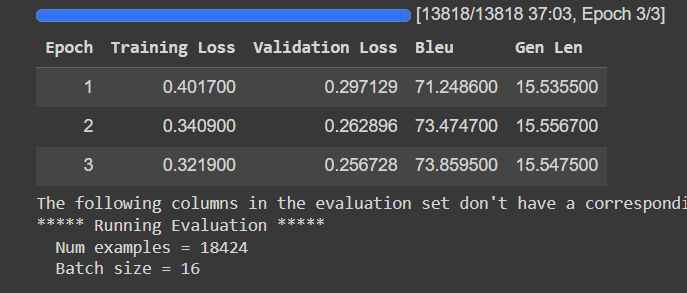

# Predict

This is our predict section. However the point of this file is to backtranslate and calculate the BLEU changed, we will temporarily leave this section here unused. However if you are willing to run this section, we will still push the model after training to huggingface site for your convenience.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("fuyulinh04/transformer_model")

model = AutoModelForSeq2SeqLM.from_pretrained("fuyulinh04/transformer_model")

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

loading file spiece.model from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--fuyulinh04--transformer_model/snapshots/8839d1dda2bcd00b4f6bba5f93382ab79b7c2783/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--fuyulinh04--transformer_model/snapshots/8839d1dda2bcd00b4f6bba5f93382ab79b7c2783/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--fuyulinh04--transformer_model/snapshots/8839d1dda2bcd00b4f6bba5f93382ab79b7c2783/tokenizer_config.json


Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--fuyulinh04--transformer_model/snapshots/8839d1dda2bcd00b4f6bba5f93382ab79b7c2783/config.json
Model config T5Config {
  "_name_or_path": "fuyulinh04/transformer_model",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length":

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--fuyulinh04--transformer_model/snapshots/8839d1dda2bcd00b4f6bba5f93382ab79b7c2783/pytorch_model.bin
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at fuyulinh04/transformer_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


In [ ]:
translators = Translator()

In [ ]:
translator = pipeline("translation", model=model, tokenizer = tokenizer)

prediction = []
answer = []

def testing_data():
  for i in range(7):
    text = dataset["train"][i]["gloss"]
    answer.append(dataset["train"][i]["text"])
    prediction.append(translators.translate(translator(text)[0]["translation_text"]).text)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/__init__.py:855: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


In [ ]:
testing_data()
print(prediction)
print(answer)

['strengthen the role of the eu', 'the vote will take place today at 12 noon .', 'copenhagen should give more than just a clear statement of intent.', 'firstly , the internal market scoreboard is a welcome tool .', 'the first is that we very much welcome the simplified structural funds .', 'member states know , the government knows , but do not always agree when it comes to money .', 'i cannot , however , support the conclusion of the rapporteur , our fellow members , carlo coelho .']
['strengthening the osce a role for the eu ', 'the vote will take place today at 12 noon .', 'copenhagen should give rise to more than a mere declaration of intent .', 'firstly , the internal market scoreboard is a welcome tool .', 'the first is that we very much welcome the simplification of the structural funds .', 'member states know , governments know , but do not always agree when it comes to money .', 'i cannot , however , support the conclusions of the rapporteur , our fellow member , carlos coelho